Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       787
           1       1.00      1.00      1.00        37

    accuracy                           1.00       824
   macro avg       1.00      1.00      1.00       824
weighted avg       1.00      1.00      1.00       824


Feature Importances:
            feature  importance
0         moisture0    0.833257
1         moisture1    0.051011
3         moisture3    0.050501
2         moisture2    0.045081
8  moisture3_change    0.005462
7  moisture2_change    0.005332
6  moisture1_change    0.004007
5  moisture0_change    0.003761
9  moisture4_change    0.000903
4         moisture4    0.000685


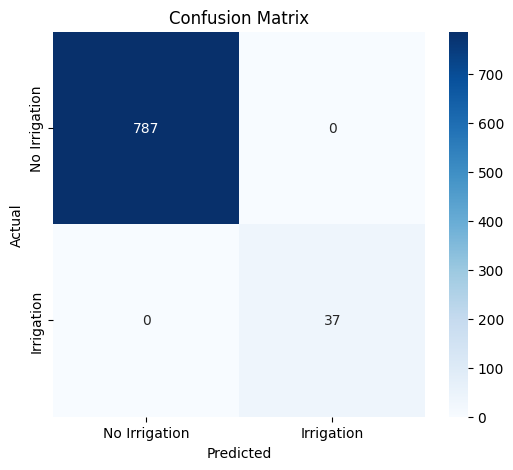

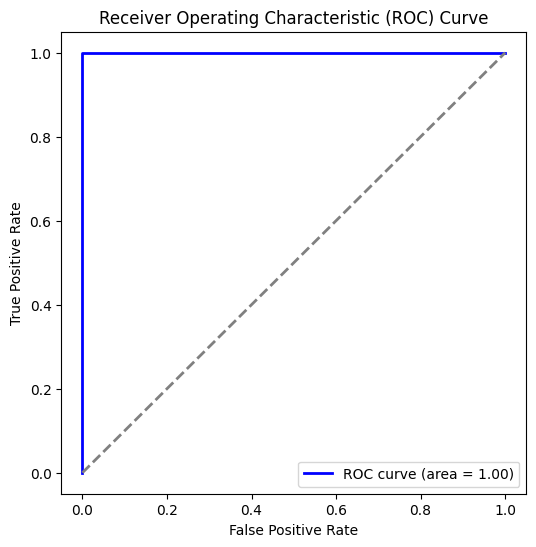

C:\Users\Gautham\AppData\Local\Temp\ipykernel_11120\1293746646.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


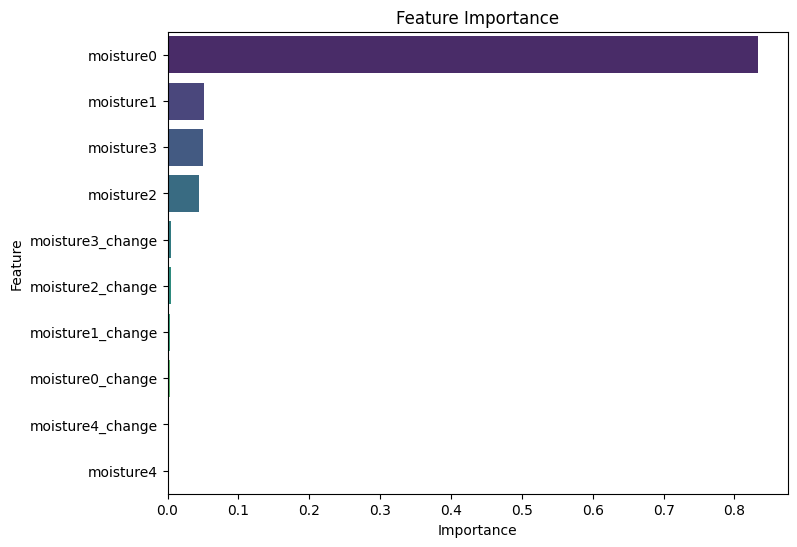

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Load the dataset
# Assuming the dataset is loaded into a DataFrame named 'data'
data = pd.read_csv('plant_vase1.csv')

# Convert time-related features into datetime
data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour', 'minute', 'second']])

# Calculate moisture change rate: rate of change in moisture level
for i in range(5):
    moisture_col = f'moisture{i}'
    data[f'{moisture_col}_change'] = data[moisture_col].diff().fillna(0)  # Change in moisture levels over time

# Set an irrigation threshold based on moisture levels, below which irrigation is needed
threshold = 0.2  # Adjust this threshold as needed
data['irrigation_needed'] = (data['moisture0'] < threshold).astype(int)  # Create target variable

# Drop unnecessary time columns for now
data = data.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'second'])

# Use the moisture columns and their changes as features
features = [f'moisture{i}' for i in range(5)] + [f'moisture{i}_change' for i in range(5)]

# Define X (features) and y (target)
X = data[features]
y = data['irrigation_needed']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model (Random Forest Classifier)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance (to see which features are contributing the most)
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Irrigation', 'Irrigation'], yticklabels=['No Irrigation', 'Irrigation'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


from sklearn.metrics import roc_curve, auc

# Get the probabilities for the positive class (Irrigation = 1)
y_prob = model.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Visualize feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
